In [24]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

In [2]:
# get the data of eurusd for given range
eur_usd_data_daily = yf.download('EURUSD=X', start='2005-01-01', end='2024-05-01')
eur_usd_data_monthly = yf.download('EURUSD=X', start='2005-01-01', end='2024-05-01', interval='1mo')

eur_usd_data_monthly.head(5)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2005-01-01,1.356594,1.362695,1.293193,1.305193,1.305193,0
2005-02-01,1.305006,1.328004,1.273707,1.321702,1.321702,0
2005-03-01,1.321895,1.347909,1.286107,1.296697,1.296697,0
2005-04-01,1.296798,1.311699,1.277906,1.292307,1.292307,0
2005-05-01,1.292307,1.298701,1.229997,1.230800,1.230800,0


In [3]:
# create a new dataframe to store the monthly data, indexes should be at the format: "2005-01"
feature_set = pd.DataFrame(index=eur_usd_data_daily.resample('M').mean().index.strftime('%Y-%m'), columns=['volatility'])

# calculate the volatility for each month
for month in feature_set.index:
    start_date = month
    end_date = pd.to_datetime(start_date) + pd.DateOffset(months=1)
    feature_set.loc[month] = round((eur_usd_data_daily.loc[start_date:end_date].Close.std()) * (len(eur_usd_data_daily.loc[start_date:end_date]) ** (1/2)) * 100, 3)

# print the monthly data
display(feature_set)

/var/folders/0p/f7tm916900ld7h415zrtvygh0000gn/T/ipykernel_93992/2961787978.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  feature_set = pd.DataFrame(index=eur_usd_data_daily.resample('M').mean().index.strftime('%Y-%m'), columns=['volatility'])


,volatility
Date,
2005-01,5.857
2005-02,7.158
2005-03,9.594
2005-04,3.802
2005-05,9.314
...,...
2023-12,5.198
2024-01,3.108
2024-02,1.903


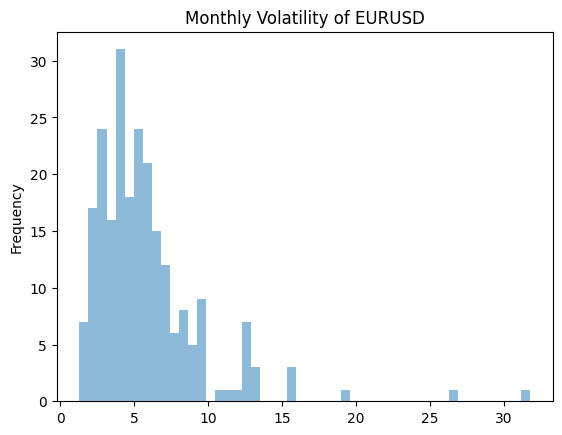

Mean: 5.7831250000000045
Standard Deviation: 3.705124144168627
Number of months that have volatility smaller than 6: 154


In [4]:
# make a histogram of the monthly volatility
feature_set['volatility'].plot.hist(bins=50, alpha=0.5, title='Monthly Volatility of EURUSD')
plt.show()

# mean and standard deviation of the monthly volatility
mean = feature_set.volatility.mean()
std = feature_set.volatility.std()
print('Mean:', mean)
print('Standard Deviation:', std)

# print the ncount of the rows that are smaller than the mean + 1 std
threshold = 6
print(f'Number of months that have volatility smaller than {threshold}:', len(feature_set[feature_set.volatility < threshold]))

In [5]:
# add a low/high column that labels the month as low or high volatility according to the threshold
feature_set['low/high'] = np.where(feature_set.volatility < threshold, 0, 1)

# print the monthly data with the low/high column
feature_set.head(10)

,volatility,low/high
Date,,
2005-01,5.857,0
2005-02,7.158,1
2005-03,9.594,1
2005-04,3.802,0
2005-05,9.314,1
2005-06,4.344,0
2005-07,4.206,0
2005-08,4.595,0
2005-09,8.196,1


In [6]:
# adding related features to the monthly data

# add the percentage change of the previous month
feature_set['abs_pct_change_monthly'] = abs(np.array(eur_usd_data_monthly['Close'].pct_change()))

feature_set.head(10)

,volatility,low/high,abs_pct_change_monthly
Date,,,
2005-01,5.857,0,NaN
2005-02,7.158,1,0.012649
2005-03,9.594,1,0.018919
2005-04,3.802,0,0.003386
2005-05,9.314,1,0.047595
2005-06,4.344,0,0.017629
2005-07,4.206,0,0.002728
2005-08,4.595,0,0.017894
2005-09,8.196,1,0.025355


In [13]:
current_month = eur_usd_data_daily.index[0].strftime('%Y-%m')
prices = []

pct_dict = {}

for idx, daily in eur_usd_data_daily.iterrows():
    if current_month != idx.strftime('%Y-%m'):
        pct_dict[current_month] = max(abs(pd.Series(prices).pct_change().max()), abs(pd.Series(prices).pct_change().min()))
        prices = []
        current_month = idx.strftime('%Y-%m')
    else:
        prices.append(daily["Close"])


# adding the values to the feature set
feature_set['max_abs_return_daily'] = feature_set.index.map(pct_dict)

feature_set

,volatility,low/high,abs_pct_change_monthly,max_abs_return_daily
Date,,,,
2005-01,5.857,1.0,NaN,0.013959
2005-02,7.158,1.0,0.012649,0.015078
2005-03,9.594,0.0,0.018919,0.012082
2005-04,3.802,1.0,0.003386,0.011495
2005-05,9.314,0.0,0.047595,0.014019
...,...,...,...,...
2023-12,5.198,0.0,0.007485,0.009872
2024-01,3.108,0.0,0.019214,0.008786
2024-02,1.903,0.0,0.000423,0.008700


In [15]:
feature_set['low/high'] = feature_set['low/high'].shift(-1)
feature_set.dropna(inplace=True)
feature_set

,volatility,low/high,abs_pct_change_monthly,max_abs_return_daily
Date,,,,
2005-02,7.158,1.0,0.012649,0.015078
2005-03,9.594,0.0,0.018919,0.012082
2005-04,3.802,0.0,0.003386,0.011495
2005-05,9.314,0.0,0.047595,0.014019
2005-06,4.344,1.0,0.017629,0.014870
...,...,...,...,...
2023-09,3.783,0.0,0.031551,0.009042
2023-10,2.144,0.0,0.002590,0.008240
2023-11,6.447,0.0,0.033788,0.016492


In [17]:
x_data = feature_set.drop(columns=['volatility', 'low/high'], axis=1)
y_data = feature_set['low/high']

In [22]:
x_data = np.array(x_data)
y_data = np.array(y_data)

# randomize the data
np.random.seed(42)
np.random.shuffle(x_data)
np.random.seed(42)
np.random.shuffle(y_data)

x_train = x_data[:int(len(x_data) * 0.8)]
x_test = x_data[int(len(x_data) * 0.8):]

y_train = y_data[:int(len(y_data) * 0.8)]
y_test = y_data[int(len(y_data) * 0.8):]

Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_894 (Dense)               │ (None, 16)             │            48 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_895 (Dense)               │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_896 (Dense)               │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_897 (Dense)               │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_898 (Dense)               │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_899 (Dense)               │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_900 (Dense)               │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_901 (Dense)               │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_902 (Dense)               │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_903 (Dense)               │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_904 (Dense)               │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_905 (Dense)               │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_906 (Dense)               │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_907 (Dense)               │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_908 (Dense)               │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_909 (Dense)               │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_910 (Dense)               │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_911 (Dense)               │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_912 (Dense)               │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_913 (Dense)               │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_914 (Dense)               │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_915 (Dense)               │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_916 (Dense)               │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_917 (Dense)               │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_918 (Dense)               │ (None, 16)             │           27

 Total params: 8,769 (34.25 KB)

 Trainable params: 8,769 (34.25 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
182/182 - 2s - 14ms/step - accuracy: 0.6648 - loss: 0.2446
Epoch 2/100
182/182 - 0s - 861us/step - accuracy: 0.6648 - loss: 0.2326
Epoch 3/100
182/182 - 0s - 855us/step - accuracy: 0.6648 - loss: 0.2250
Epoch 4/100
182/182 - 0s - 851us/step - accuracy: 0.6648 - loss: 0.2258
Epoch 5/100
182/182 - 0s - 847us/step - accuracy: 0.6648 - loss: 0.2244
Epoch 6/100
182/182 - 0s - 851us/step - accuracy: 0.6648 - loss: 0.2240
Epoch 7/100
182/182 - 0s - 852us/step - accuracy: 0.6648 - loss: 0.2240
Epoch 8/100
182/182 - 0s - 862us/step - accuracy: 0.6648 - loss: 0.2244
Epoch 9/100
182/182 - 0s - 868us/step - accuracy: 0.6648 - loss: 0.2243
Epoch 10/100
182/182 - 0s - 874us/step - accuracy: 0.6648 - loss: 0.2246
Epoch 11/100
182/182 - 0s - 870us/step - accuracy: 0.6648 - loss: 0.2243
Epoch 12/100
182/182 - 0s - 866us/step - accuracy: 0.6648 - loss: 0.2241
Epoch 13/100
182/182 - 0s - 873us/step - accuracy: 0.6648 - loss: 0.2244
Epoch 14/100
182/182 - 0s - 870us/step - accuracy: 0.664

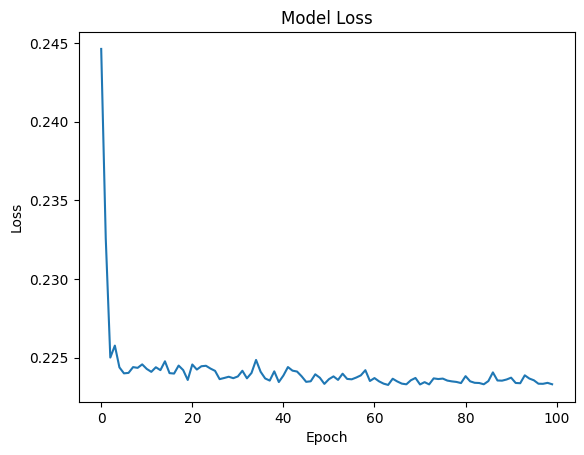

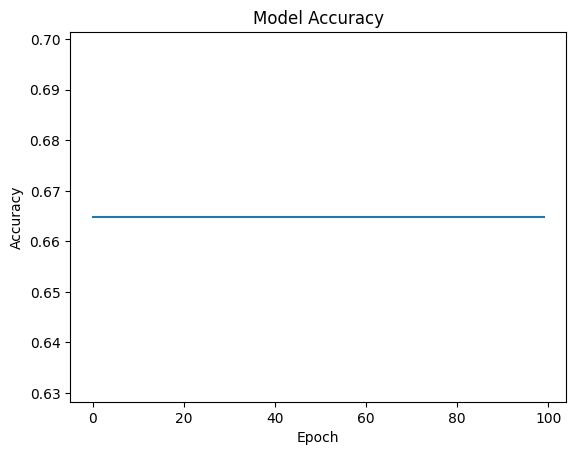

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6784 - loss: 0.2203  
Test Loss: 0.2227160632610321
Test Accuracy: 0.6739130616188049
{'accuracy': [0.6648351550102234, 0.6648351550102234, 0.6648351550102234, 0.6648351550102234, 0.6648351550102234, 0.6648351550102234, 0.6648351550102234, 0.6648351550102234, 0.6648351550102234, 0.6648351550102234, 0.6648351550102234, 0.6648351550102234, 0.6648351550102234, 0.6648351550102234, 0.6648351550102234, 0.6648351550102234, 0.6648351550102234, 0.6648351550102234, 0.6648351550102234, 0.6648351550102234, 0.6648351550102234, 0.6648351550102234, 0.6648351550102234, 0.6648351550102234, 0.6648351550102234, 0.6648351550102234, 0.6648351550102234, 0.6648351550102234, 0.6648351550102234, 0.6648351550102234, 0.6648351550102234, 0.6648351550102234, 0.6648351550102234, 0.6648351550102234, 0.6648351550102234, 0.6648351550102234, 0.6648351550102234, 0.6648351550102234, 0.6648351550102234, 0.6648351550102234, 0.6648351550102234, 0.6648351550102234, 0.6648351

In [51]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

# Define the model
model = Sequential()

# Add input layer
model.add(Dense(16, input_dim=2, activation='relu'))

# Add hidden layers
for _ in range(32):
    model.add(Dense(16, activation='relu'))

# Add output layer
model.add(Dense(1, activation='sigmoid'))

# Define the optimizer with a custom learning rate
custom_optimizer = Adam(learning_rate=0.0003)  # Change the learning rate as needed

# Compile the model with the custom optimizer
model.compile(optimizer=custom_optimizer, loss='mse', metrics=['accuracy'])
print(model.summary())
# Train the model
history = model.fit(x_train, y_train, epochs=100, batch_size=1, verbose=2)

# Plot the loss function graph
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

# Test the model
loss, accuracy = model.evaluate(x_test, y_test)

print("Test Loss:", loss)
print("Test Accuracy:", accuracy)
print(history.history)
